In [48]:
""" Testing productivity: generalisation to longer addition sequences.
    Script tests how RNNs trained on simple addition sequences generalises to longer sequences.
    1. Performance accuracy as a function of test sequence length
    2. 2D MDS plots to visualise hidden layer activations
    3. Control model regression """
    

' Testing productivity: generalisation to longer addition sequences.\n    Script tests how RNNs trained on simple addition sequences generalises to longer sequences.\n    1. Performance accuracy as a function of test sequence length\n    2. 2D MDS plots to visualise hidden layer activations\n    3. Control model regression '

In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D
import statannot

from cryptic_rnn import *
from performance_analysis import *

## RNN params

In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

## Sequences

In [9]:
# generate addition sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
# randomly select values for each input
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]

# all simple addition sequences
trial_list = []
for s in range(1, len(all_syms)+1):
    trial_list += (generate_pairs(ops, all_syms, cue_dict, s))
trial_list
# generate primitive and balancing seqs
primitives = generate_pos_primitives(all_syms, cue_dict)
balanced_prims = generate_complex_primitives(ops, all_syms, cue_dict)
train_trials = [trial for trial in trial_list if trial not in balanced_prims] # remove any seqs in balanced set
# curricula seqs
basic_train = train_trials[:2] # select first 2 seqs
trainseqs_b = basic_train + balanced_prims # balanced curriculum
trainseqs_p = basic_train + primitives # primitive curriculum
# test set
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict) 
testseqs1 = [t for t in testseqs if t not in trainseqs_b]

# 2, 3 and 4 step addition sequences
testseqs2 = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 2) 
testseqs3 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 3), 64) 
testseqs4 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 4), 64)

all_testseqs = [testseqs1,testseqs2,testseqs3,testseqs4]

In [11]:
# load trained RNNs on simple addition sequences
save_dir =  '../results/fraction_inputs/4_inputs'
with open(save_dir, 'rb') as f:
    res_t = pickle.load(f)


In [ ]:
# extract RNN set trained on 2 base trials
res2 = res_t[1]

# 1. Performance scores
MSE loss and prediction R2 scores as test sequence length increases

In [12]:
def extract_step_curr_r2(res_step, all_testseqs):
    """ function to extract R2 scores for RNN predictions"""
    
    cue_dicts = res_step['cue_dicts']
    mods_b = res_step['mods_b']
    mods_p = res_step['mods_p']
    
    curricula = []
    add_steps = []
    r2_vals = []

    for i, test_seq in enumerate(all_testseqs):
        tsq = []
        for cd in cue_dicts:
            testseqs = change_dict(test_seq, cd)
            test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
            tsq.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))
        
        r2reses_p = get_r2_and_preds(mods_p, tsq, hidden_size=20)['ind_r2s']
        r2reses_b = get_r2_and_preds(mods_b, tsq, hidden_size=20)['ind_r2s']
        
        r2_vals = r2_vals + r2reses_b + r2reses_p
        curricula = curricula + ['Balanced']*len(r2reses_b) + ['Primitive']*len(r2reses_p)
        add_steps += [i+1]*len(r2reses_b + r2reses_p)
        
    return {'add_steps': add_steps, 'curricula':curricula , 'r2s': r2_vals}

def ind_losses(mods, test_seqs, cuedicts, hidden_size=20, num_classes=22):
    losses = []
    for i, mod in enumerate(mods):
        cuedict = cuedicts[i]
        testseqs = change_dict(test_seqs, cuedict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
        losses.append(test_modloss(mod, [testset], criterion)[0])
    return losses

def extract_step_curr_mse(res_step, all_testseqs):
    
    """ function to extract MSE loss for RNN predictions """
    
    criterion = nn.MSELoss()
    
    cue_dicts = res_step['cue_dicts']
    mods_b = res_step['mods_b']
    mods_p = res_step['mods_p']
    
    curricula = []
    add_steps = []
    mse_vals = []

    for i, test_seq in enumerate(all_testseqs):
        tsq = []
        for cd in cue_dicts:
            testseqs = change_dict(test_seq, cd)
            test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
            tsq.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))
        
        mse_p = ind_losses(mods_p, testseqs, cue_dicts, hidden_size=20)
        mse_b = ind_losses(mods_b, testseqs, cue_dicts, hidden_size=20)
        
        mse_vals = mse_vals + mse_b + mse_p
        curricula = curricula + ['Balanced']*len(mse_b) + ['Primitive']*len(mse_p)
        add_steps += [i+1]*len(mse_b + mse_p)
        
    return {'add_steps': add_steps, 'curricula':curricula , 'mse': mse_vals}

# custom legend 
legend_elements_bp = [Line2D([0], [0], marker="o", color='w', markerfacecolor =bp_colors[0], markersize=msize, label='Balanced'),
                   Line2D([0], [0], marker="o", color='w', markerfacecolor =bp_colors[1], markersize=msize, label='Primitive')] 


## MSE loss for generalisation to longer addition sequences

In [15]:
# MSE scores
mseres_2 = extract_step_curr_mse(res2, all_testseqs)
df2 = pd.DataFrame({'Curricula': mseres_2['curricula'], '$MSE$': mseres_2['mse'], \
                    'Addition steps': mseres_2['add_steps']})

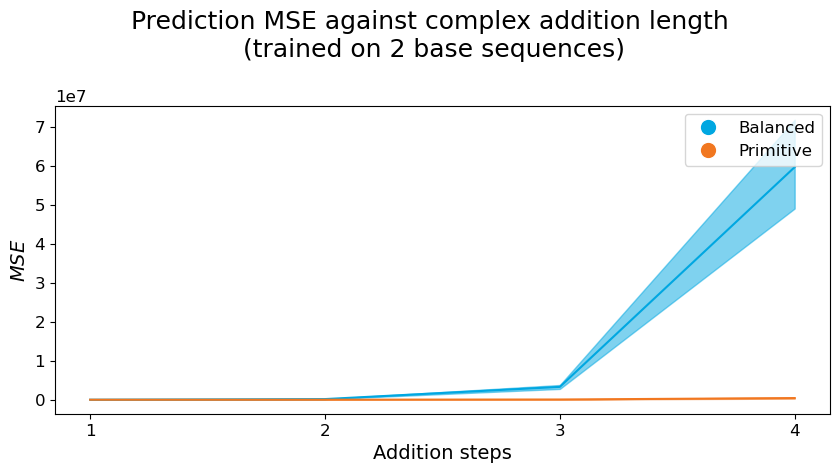

In [17]:
## 2 training trials
fig, ax = plt.subplots(figsize = (10,4))
sns.lineplot(data = df2, x='Addition steps', y='$MSE$', hue='Curricula', palette = bp_pal)
plt.setp(ax.collections, alpha=.5)
# ax.set_ylim(0,10000)
ax.set_xticks(np.arange(1,5))
plt.suptitle('Prediction MSE against complex addition length\n (trained on 2 base sequences)', y=1.12)

#
plt.legend(handles = legend_elements_bp)

## R2 score for generalisation to longer addition sequences

In [19]:
# R2 scores
r2res_2 = extract_step_curr_r2(res2, all_testseqs)
df2 = pd.DataFrame({'Curricula': r2res_2['curricula'], '$R^2$': r2res_2['r2s'],\
                    'Addition steps': r2res_2['add_steps']})

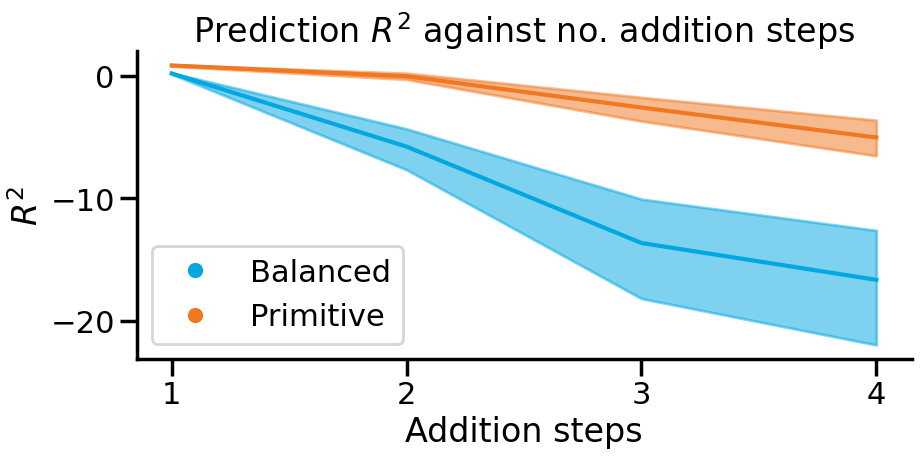

In [20]:
# colour palette
bp_pal = {'Balanced': '#00A7E1', 'Primitive':'#F17720'}
sns.set_context('poster')
## 2 training trials
fig, ax = plt.subplots(figsize = (10,4))
sns.lineplot(data = df2, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal)
plt.setp(ax.collections, alpha=.5)
# ax.set_ylim(-5,1.2)
# ax.set_yticks(np.arange(-1,1.1,0.5))
ax.set_xticks(np.arange(1,5))
plt.title('Prediction $R^2$ against no. addition steps')

#
plt.legend(handles = legend_elements_bp)
sns.despine()

# 2. MDS
Multidimensional scaling visualisations for hidden layer activations

In [22]:
# plotting variables
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32
msize = 12
# legend
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' + A _ _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' + B _ _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' + C _ _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' + D _ _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B _'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D _'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=ca, markersize=msize, label=' _ _ + A'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cb, markersize=msize, label=' _ _ + B'), 
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cc, markersize=msize, label=' _ _ + C'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cd, markersize=msize, label=' _ _ + D')
                   ]

# MDS plotting function
def MDS_plot_single(ax, meanRDM, testseqs, MDStype = 'MDS', title = '', plotlines=True, rand_state=0, min_dim=0):
    
    """ 2D MDS plots for given RDM """

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM)
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=4, color = colors3[i], s=180)
        
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
   

In [31]:
# Calculate RDM for hidden layer activations for the 2 step addition sequences
Tmax = 2*len(testseqs2[0][:-1])-1-1
allrdms2 = calculate_RDMs(res2, testseqs2, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

## MDS plot for primitive curriculum RNNs

In [33]:
dps = []
for j in [0,2,4]:
    dps.append(np.array(allrdms2['rdms_p'][j]).mean(axis=0))

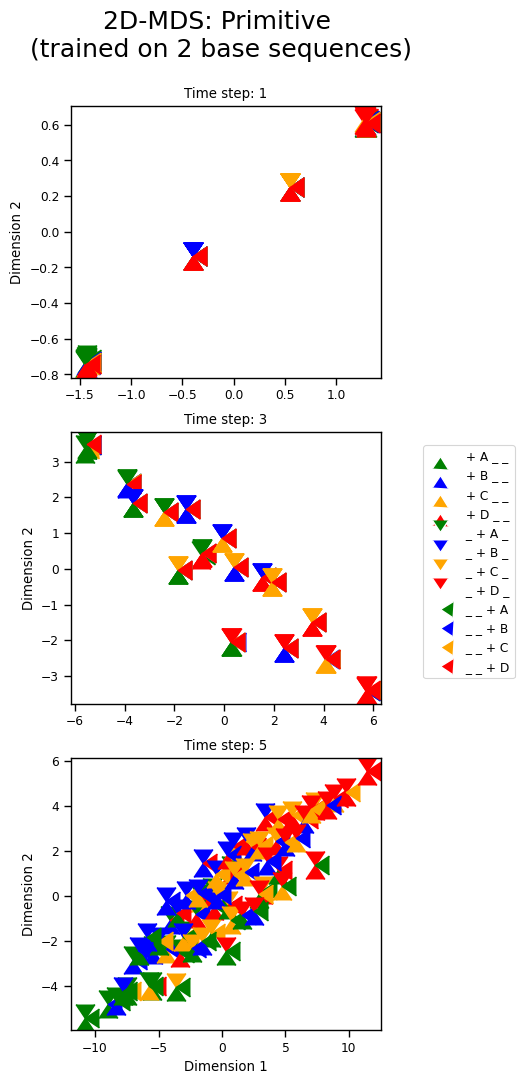

In [34]:
sns.set_context('paper')
plt.rcParams['figure.figsize'] = (4,12)
fig, ax = plt.subplots(3,1)
ax = ax.flatten()

for i in range(3):
    MDS_plot_single(ax[i], dps[i], testseqs2, rand_state=9)
    ax[i].title.set_text('Time step: '+str(2*i+1))
    ax[i].set_xlabel('')
ax[-1].set_xlabel('Dimension 1')
plt.suptitle('2D-MDS: Primitive \n(trained on 2 base sequences)', y=0.96)
fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))
#fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))

#loc='center left' bbox_to_anchor=(1, 0.5)

## MDS plot for balanced curriculum RNNs

In [27]:
dbs = []
for j in [0,2,4]:
    dbs.append(np.array(allrdms2['rdms_b'][j]).mean(axis=0))

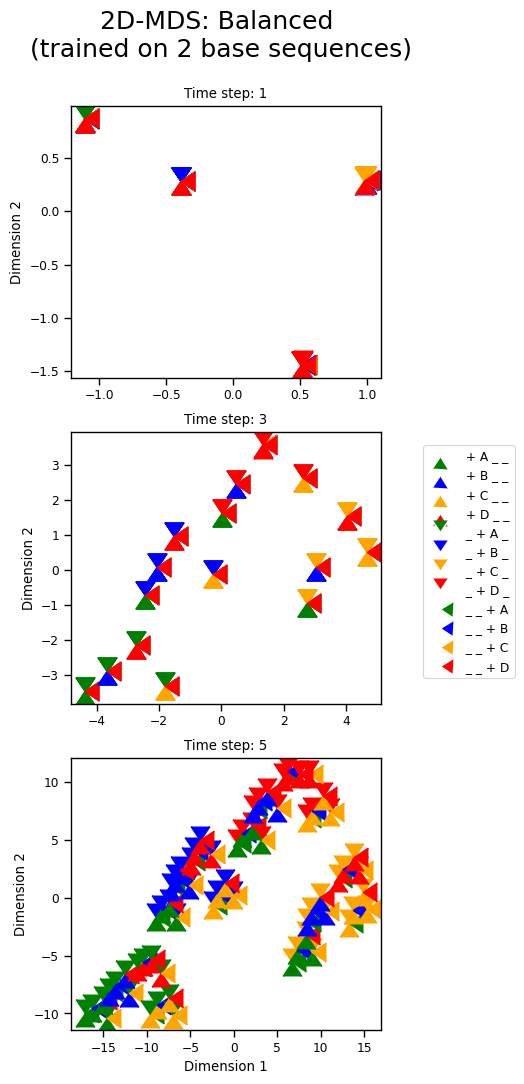

In [29]:
plt.rcParams['figure.figsize'] = (4,12)
fig, ax = plt.subplots(3,1)
ax = ax.flatten()

for i in range(3):
    MDS_plot_single(ax[i], dbs[i], testseqs2, rand_state=9)
    ax[i].title.set_text('Time step: '+str(2*i+1))
    ax[i].set_xlabel('')
ax[-1].set_xlabel('Dimension 1')
plt.suptitle('2D-MDS: Balanced \n(trained on 2 base sequences)', y=0.96)
fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))

#loc='center left' bbox_to_anchor=(1, 0.5)

# 3. Control models

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statannot
from sklearn.linear_model import LinearRegression

bp_colors_dark = ['#003D70', '#AE4F0A']

In [40]:
def tuple_output(tuple_step, cue_dict):
    out = cue_dict[tuple_step[1]]
    if tuple_step[0]=='-':
        out = -1*out
    return out

def control_importance(rdm, all_seqs, cuedict, control_mod):
    """Multiple linear regression with control models"""
    newseqs = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in newseqs]
    truth_RDM = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)
       
    outs_aug = [tuple_output(t[0], cuedict) for t in newseqs]
    aug_RDM = abs(np.array([outs_aug]*64) - np.array([outs_aug]*64).T)

    outs_simple = [tuple_output(t[0], cuedict) + tuple_output(t[1], cuedict) for t in newseqs]
    simple_RDM = abs(np.array([outs_simple]*64) - np.array([outs_simple]*64).T)

    y = rdm.reshape(-1)
    x_truth = truth_RDM.reshape(-1,1) 
    x_aug = aug_RDM.reshape(-1,1) 
    x_simple = simple_RDM.reshape(-1,1) 
    
    r_sqs = []
    for xvals in [x_aug, x_simple, x_truth]:
        model = LinearRegression().fit(xvals, y)
        r_sqs.append(model.score(xvals, y))
    

    x = pd.DataFrame({'ground_truth': x_truth.reshape(-1),
                      'aug_control': x_aug.reshape(-1),
                      'simple_control': x_simple.reshape(-1)})

    lm = ols('y ~ simple_control + ground_truth +  aug_control',x).fit()
    r_sqs.append(lm.rsquared)
    var_exp = np.array(r_sqs)
         
    return var_exp

def get_step_coeffs(RDMs, step_num,  all_seqs, cue_dicts, control_mod=None):
    N = len(RDMs[0])
    if (control_mod == 'aug') or (control_mod == 'ground_truth') or (control_mod == 'simple_control'):
        control_mod_names = [control_mod]*N
        importance_vals = np.empty((0,1))
    else:
        control_mod_names = ['augend']*N + ['simple']*N + ['ground truth']*N + ['multiple']*N
        importance_vals = np.empty((0,4))
    for i, rdm_mat in enumerate(RDMs[step_num]):
        imps = control_importance(rdm_mat, all_seqs, cue_dicts[i], control_mod)
        importance_vals = np.vstack([importance_vals, imps])
   
    coeff_vals = importance_vals.T.reshape(-1)
    
    return coeff_vals, control_mod_names

def all_steps_coeffs(RDM_set, control_mod=None):
    all_coeffs = np.empty((0,1))
    all_controls = []
    step_num = []
    for st in range(4):
        print('step ', st)
        step_coeffs, step_mods = get_step_coeffs(RDM_set,step_num=st,  control_mod=control_mod)
        all_coeffs = np.append(all_coeffs, step_coeffs)
        all_controls += step_mods
        step_num += [st+2]*len(step_mods)
    return pd.DataFrame({'step': step_num, 'variance explained': all_coeffs, 'control':all_controls})

In [41]:
# Extract RNN hidden layer activation RDMs

cuedicts = res2['cue_dicts']
coefs5b, names5b = get_step_coeffs(allrdms2['rdms_b'],5, testseqs2, cuedicts)
coefs5p, names5p = get_step_coeffs(allrdms2['rdms_p'],5, testseqs2, cuedicts)

coefs = np.append(coefs5b, coefs5p)
curricula = ['Balanced']*len(coefs5b) + ['Primitive']*len(coefs5p)
controls = names5b + names5p
r2_df5 = pd.DataFrame({'R2': coefs, 'Control': controls, 'Curricula': curricula})

# Control model RDMs

newseqs = change_dict(testseqs2, cue_dict)
outs_truth = [t[-1] for t in newseqs]
truth_RDM = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)

outs_aug = [tuple_output(t[0], cue_dict) for t in newseqs]
aug_RDM = abs(np.array([outs_aug]*64) - np.array([outs_aug]*64).T)

outs_simple = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) for t in newseqs]
simple_RDM = abs(np.array([outs_simple]*64) - np.array([outs_simple]*64).T)


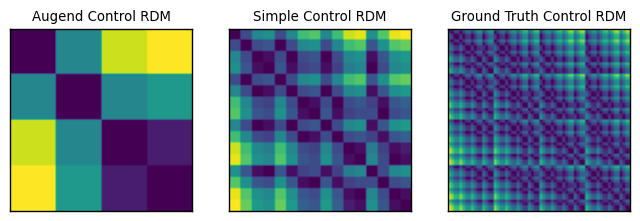

In [43]:
# Plot control RDMs

fig, axs = plt.subplots(1,3, figsize=(8,6))
axs = axs.flatten()
controls_rdms = [aug_RDM, simple_RDM, truth_RDM]
control_names = ['Augend', 'Simple', 'Ground Truth']
for i, r in enumerate(controls_rdms):
    ax = axs[i]
    ax.imshow(r)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(control_names[i]+' Control RDM')


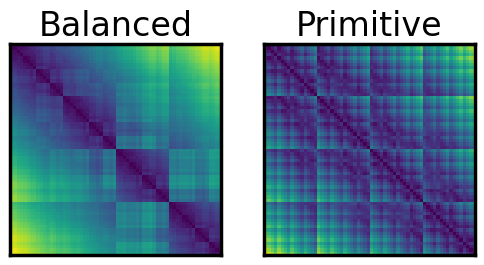

In [49]:
# Plot average RNN RDMs

fig, axs = plt.subplots(1,2, figsize = (6,3))
axs = axs.flatten()
axs[0].imshow(np.array(allrdms2['rdms_b'][-1]).mean(axis=0))
axs[0].set_title('Balanced')
axs[1].imshow(np.array(allrdms2['rdms_p'][-1]).mean(axis=0))
axs[1].set_title('Primitive')
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Balanced v.s. simple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.546e-32 stat=2.210e+02
Using zero_method  wilcox
augend_Balanced v.s. augend_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.011e-13 stat=3.996e+03
Using zero_method  wilcox
ground truth_Balanced v.s. ground truth_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.832e-34 stat=1.000e+00
Using zero_method  wilcox
multiple_Balanced v.s. multiple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.002e-33 stat=3.700e+01


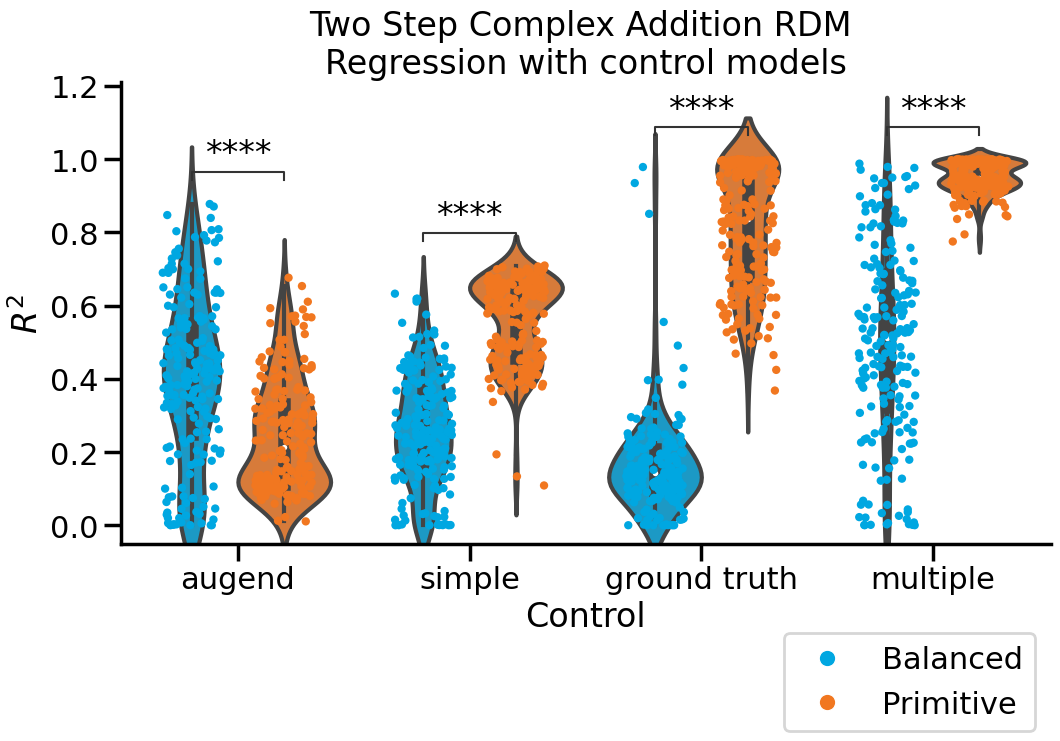

In [50]:
# Plot variance explained by each control RDM

sns.set_context('poster')
fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data = r2_df5, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df5, x='Control', y='R2', hue='Curricula', palette = bp_pal,dodge = True, jitter=0.25, s=6)
#plt.setp(ax.collections, alpha=.5)

statannot.add_stat_annotation(
    ax,
    data=r2_df5,
    x= 'Control',
    y='R2',
    hue = 'Curricula',
    box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitive')),
                   (('simple','Balanced'), ('simple','Primitive')),
                  (('augend','Balanced'), ('augend','Primitive')),
                  (('multiple','Balanced'), ('multiple','Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)
plt.legend(handles = legend_elements_bp, loc='right', bbox_to_anchor=(1,-0.3))
#plt.suptitle('Two Step Complex Addition RDM \nRegression with control models', y=1.09)
ax.title.set_text('Two Step Complex Addition RDM \nRegression with control models')
ax.set_ylabel('$R^2$')
sns.despine()